# Rock–Paper–Scissors (RPS) — CNN Classification

**Goal:** Train and compare three simple CNN models (A/B/C) on RPS images (.png) to classify {rock, paper, scissors}.

**Libraries:** torch, torchvision, numpy, pandas, scikit-learn, Pillow, matplotlib, tqdm

# Imports, config, seeding

I imported only essential libraries, fixed random seeds, set image size=128, batch=64, and created output directories.

In [3]:
import time

import os, sys, math, random, pathlib, time
from dataclasses import dataclass
from typing import Tuple, List, Dict

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

from tqdm import tqdm

# --- Config ---
PROJECT_ROOT = pathlib.Path(".").resolve()
RAW_DIR      = PROJECT_ROOT / "data" / "raw"
SPLIT_DIR    = PROJECT_ROOT / "data" / "splits"
OUT_CKPT     = PROJECT_ROOT / "outputs" / "checkpoints"
OUT_PLOTS    = PROJECT_ROOT / "outputs" / "plots"

CLASSES = ["rock", "paper", "scissors"]
CLASS_TO_IDX = {c: i for i, c in enumerate(CLASSES)}
IDX_TO_CLASS = {i: c for c, i in CLASS_TO_IDX.items()}


print("Class → index mapping:", CLASS_TO_IDX)

IMG_SIZE = 128
BATCH_SIZE = 64
NUM_WORKERS = 0
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

EPOCHS_A = 20
EPOCHS_B_DEFAULT = 20
EPOCHS_C = 20

LR_DEFAULT = 1e-3
WEIGHT_DECAY = 1e-4

NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD  = [0.229, 0.224, 0.225]

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SPLIT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CKPT.mkdir(parents=True, exist_ok=True)
OUT_PLOTS.mkdir(parents=True, exist_ok=True)

print(f"Device: {DEVICE}")
print("Versions:",
      f"torch {torch.__version__}",
      f"| torchvision {torch.__version__}",
      f"| numpy {np.__version__}",
      f"| pandas {pd.__version__}", sep="\n")


Class → index mapping: {'rock': 0, 'paper': 1, 'scissors': 2}
Device: cpu
Versions:
torch 2.8.0+cpu
| torchvision 2.8.0+cpu
| numpy 2.3.3
| pandas 2.3.3


# Dataset sanity & counts

I scanned `data/raw/{rock,paper,scissors}` recursively for `.png` files and previewed one sample per class.

*The scan confirmed that the dataset was loaded correctly and contains a balanced number of rock, paper, and scissors images.*

PNG counts per class: {'rock': 726, 'paper': 712, 'scissors': 750} | Total: 2188


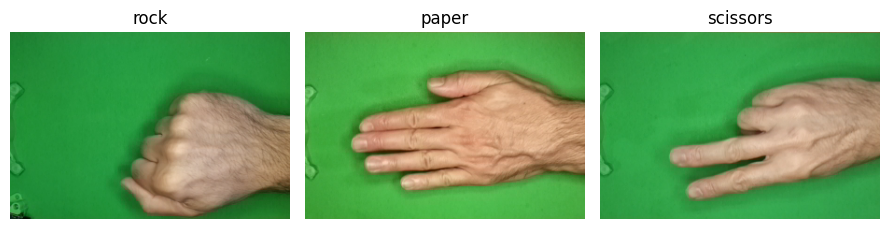

In [4]:
assert RAW_DIR.exists(), f"Dataset not found at {RAW_DIR}. Expected data/raw/{rock,paper,scissors} structure."

def scan_counts(root: pathlib.Path) -> Dict[str, int]:
    counts = {c:0 for c in CLASSES}
    for cls in CLASSES:
        for p in root.rglob(f"{cls}/*.png"):
            counts[cls] += 1
    return counts

counts = scan_counts(RAW_DIR)
print("PNG counts per class:", counts, "| Total:", sum(counts.values()))

fig, axes = plt.subplots(1, len(CLASSES), figsize=(9, 3))
for i, cls in enumerate(CLASSES):
    sample = next(iter(RAW_DIR.rglob(f"{cls}/*.png")), None)
    if sample and sample.exists():
        img = Image.open(sample).convert("RGB")
        axes[i].imshow(img); axes[i].set_title(cls); axes[i].axis("off")
    else:
        axes[i].text(0.5, 0.5, f"No {cls} image found", ha="center")
        axes[i].axis("off")
plt.tight_layout(); plt.show()


# Make stratified splits (train/val/test) → CSV

I built a file list (path+label) and created stratified **70/15/15** splits; saved to `data/splits/train.csv`, `val.csv`, and `test.csv`.

*The splits were successfully created and stored, guaranteeing the same 70/15/15 distribution for every future run.*

In [5]:
rows = []
for cls in CLASSES:
    for p in RAW_DIR.rglob(f"{cls}/*.png"):
        rows.append({"filepath": str(p), "label": cls})
df = pd.DataFrame(rows, columns=["filepath", "label"])
print("All images found:", len(df))
display(df.head())

train_csv = SPLIT_DIR / "train.csv"
val_csv   = SPLIT_DIR / "val.csv"
test_csv  = SPLIT_DIR / "test.csv"

if not (train_csv.exists() and val_csv.exists() and test_csv.exists()):
    train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["label"], random_state=SEED)
    val_df, test_df   = train_test_split(temp_df, test_size=0.50, stratify=temp_df["label"], random_state=SEED)
    train_df.to_csv(train_csv, index=False)
    val_df.to_csv(val_csv, index=False)
    test_df.to_csv(test_csv, index=False)
    print("Created new splits at", SPLIT_DIR)
else:
    print("Found existing splits at", SPLIT_DIR)

train_df = pd.read_csv(train_csv)
val_df   = pd.read_csv(val_csv)
test_df  = pd.read_csv(test_csv)

print("Split sizes:", len(train_df), len(val_df), len(test_df))
print("Train dist:", train_df["label"].value_counts().to_dict())
print("Val   dist:", val_df["label"].value_counts().to_dict())
print("Test  dist:", test_df["label"].value_counts().to_dict())


All images found: 2188


,filepath,label
0,C:\Users\damir\PycharmProjects\rps nn\data\raw...,rock
1,C:\Users\damir\PycharmProjects\rps nn\data\raw...,rock
2,C:\Users\damir\PycharmProjects\rps nn\data\raw...,rock
3,C:\Users\damir\PycharmProjects\rps nn\data\raw...,rock
4,C:\Users\damir\PycharmProjects\rps nn\data\raw...,rock


Found existing splits at C:\Users\damir\PycharmProjects\rps nn\data\splits
Split sizes: 1531 328 329
Train dist: {'scissors': 525, 'rock': 508, 'paper': 498}
Val   dist: {'scissors': 112, 'rock': 109, 'paper': 107}
Test  dist: {'scissors': 113, 'rock': 109, 'paper': 107}


# Dataset class & transforms

I defined simple transforms (Resize(128), Normalize) with light train augments (flip/rotation); created a CSV-backed dataset to respect exact splits.

*The preprocessing pipeline was established so every image is standardized and augmented consistently before training.*

In [6]:
train_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ToTensor(),
    T.Normalize(mean=NORM_MEAN, std=NORM_STD),
])

eval_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=NORM_MEAN, std=NORM_STD),
])

class CsvImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, classes: List[str], transform=None):
        self.df = df.reset_index(drop=True)
        self.classes = classes
        self.class_to_idx = {c:i for i,c in enumerate(classes)}
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        path = row["filepath"]
        label = self.class_to_idx[row["label"]]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label, path


# DataLoaders

I wrapped datasets in DataLoaders (batch **64**, shuffle on train) and fetched a sample batch to verify shapes.

*The loaders returned correctly shaped tensors, proving that images and labels are being read and prepared as expected.*

In [7]:
train_ds = CsvImageDataset(train_df, CLASSES, transform=train_tfms)
val_ds   = CsvImageDataset(val_df,   CLASSES, transform=eval_tfms)
test_ds  = CsvImageDataset(test_df,  CLASSES, transform=eval_tfms)

train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_ld   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_ld  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

batch = next(iter(train_ld))
print("Batch shapes:", batch[0].shape, batch[1].shape)


Batch shapes: torch.Size([64, 3, 128, 128]) torch.Size([64])


# Plot helpers & metric utils

I added small utilities to plot training curves, draw a confusion matrix, and show a misclassified gallery.

*These utilities now make it easy to visualize training progress and evaluate model performance clearly.*

In [8]:
def plot_curves(history: dict, save_path: pathlib.Path):
    epochs = range(1, len(history["train_loss"])+1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="train")
    plt.plot(epochs, history["val_loss"],   label="val")
    plt.title("Loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="train")
    plt.plot(epochs, history["val_acc"],   label="val")
    plt.title("Accuracy"); plt.xlabel("epoch"); plt.ylabel("acc"); plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()

def plot_confusion(cm: np.ndarray, class_names: List[str], save_path: pathlib.Path, title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    ax.set_xticks(range(len(class_names))); ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticks(range(len(class_names))); ax.set_yticklabels(class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]), ha="center", va="center")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()

def misclass_gallery(paths: List[str], y_true: List[int], y_pred: List[int], class_names: List[str], n=12, save_path: pathlib.Path=None):
    idxs = [i for i in range(len(paths)) if y_true[i] != y_pred[i]]
    if not idxs:
        print("No misclassifications found.")
        return
    idxs = idxs[:n]
    cols = min(6, n); rows = math.ceil(len(idxs)/cols)
    plt.figure(figsize=(3*cols, 3*rows))
    for k, i in enumerate(idxs):
        img = Image.open(paths[i]).convert("RGB")
        plt.subplot(rows, cols, k+1)
        plt.imshow(img); plt.axis("off")
        plt.title(f"T:{class_names[y_true[i]]}\nP:{class_names[y_pred[i]]}", fontsize=9)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()


# Models A/B/C

I implemented three CNNs with increasing capacity (A tiny, B small with dropout, C small+ wider/deeper).

In [9]:
class ModelA(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear((IMG_SIZE//4)*(IMG_SIZE//4)*32, 64), nn.ReLU(inplace=True),
            nn.Linear(64, num_classes)
        )
    def forward(self, x): return self.classifier(self.features(x))

class ModelB(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.5),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear((IMG_SIZE//4)*(IMG_SIZE//4)*64, 128), nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )
    def forward(self, x): return self.classifier(self.features(x))

class ModelC(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear((IMG_SIZE//4)*(IMG_SIZE//4)*128, 256), nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x): return self.classifier(self.features(x))

def count_params(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for Model in (ModelA, ModelB, ModelC):
    m = Model(num_classes=len(CLASSES))
    print(Model.__name__, "trainable params:", f"{count_params(m):,}")


ModelA trainable params: 2,102,499
ModelB trainable params: 8,449,635
ModelC trainable params: 33,694,883


# Train/eval functions

I wrote generic training and evaluation loops (fixed epochs, AdamW, best checkpoint by val accuracy).

*The generic training routine now manages all models uniformly and automatically tracks and saves the best checkpoints.*

In [13]:
def accuracy_from_logits(logits: torch.Tensor, y: torch.Tensor) -> float:
    preds = logits.argmax(1)
    return (preds == y).float().mean().item()

@torch.no_grad()
def run_eval(model: nn.Module, loader: DataLoader, criterion, device=DEVICE):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y, _ in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        total_loss += loss.item() * x.size(0)
        total_acc  += (out.argmax(1) == y).sum().item()
        n += x.size(0)
    return total_loss / n, total_acc / n

def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                epochs: int,
                lr: float = LR_DEFAULT,
                weight_decay: float = WEIGHT_DECAY,
                device: str = DEVICE,
                ckpt_name: str = "best_model.pt"):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_val_acc, best_path = -1.0, OUT_CKPT / ckpt_name

    for ep in range(1, epochs+1):
        model.train()
        ep_loss, ep_correct, ep_n = 0.0, 0, 0
        for x, y, _ in tqdm(train_loader, desc=f"Epoch {ep}/{epochs}", leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            ep_loss += loss.item() * x.size(0)
            ep_correct += (out.argmax(1) == y).sum().item()
            ep_n += x.size(0)

        tr_loss = ep_loss / ep_n
        tr_acc  = ep_correct / ep_n
        va_loss, va_acc = run_eval(model, val_loader, criterion, device)

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)

        print(f"[{ep:02d}] train_loss={tr_loss:.4f} acc={tr_acc:.3f} | val_loss={va_loss:.4f} acc={va_acc:.3f}")

        # Save best by validation accuracy
        if va_acc > best_val_acc:
            best_val_acc = va_acc
            torch.save({"model_state": model.state_dict(),
                        "val_acc": best_val_acc,
                        "epoch": ep},
                       best_path)

    return history, best_path

@torch.no_grad()
def final_test_report(model: nn.Module, loader: DataLoader, class_names: List[str], device=DEVICE):
    model.eval()
    ys, ps, paths = [], [], []
    for x, y, p in loader:
        x = x.to(device)
        out = model(x)
        preds = out.argmax(1).cpu().tolist()
        ys.extend(y.tolist())
        ps.extend(preds)
        paths.extend(p)

    report = classification_report(ys, ps, target_names=class_names, digits=4, output_dict=False)
    cm = confusion_matrix(ys, ps)
    return ys, ps, paths, report, cm

def count_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def timed_train(model, *args, **kwargs):
    """Wraps train_model(...) to measure wall-clock time."""
    t0 = time.time()
    history, ckpt_path = train_model(model, *args, **kwargs)
    secs = time.time() - t0
    return history, ckpt_path, secs


# Train & evaluate Model A

I trained **Model A** for **20 epochs** and evaluated on the test set.

*Model A trained smoothly and produced a valid baseline for comparison with deeper architectures.*

Model A trainable params: 2,102,499


[01] train_loss=1.2396 acc=0.427 | val_loss=0.9715 acc=0.695


[02] train_loss=0.7376 acc=0.743 | val_loss=0.5801 acc=0.768


[03] train_loss=0.4823 acc=0.836 | val_loss=0.4708 acc=0.814


[04] train_loss=0.3593 acc=0.878 | val_loss=0.3648 acc=0.863


[05] train_loss=0.2527 acc=0.919 | val_loss=0.2884 acc=0.887


[06] train_loss=0.1764 acc=0.953 | val_loss=0.1918 acc=0.930


[07] train_loss=0.1159 acc=0.969 | val_loss=0.1883 acc=0.930


[08] train_loss=0.0919 acc=0.971 | val_loss=0.1680 acc=0.948


[09] train_loss=0.0727 acc=0.983 | val_loss=0.1838 acc=0.930


[10] train_loss=0.0594 acc=0.987 | val_loss=0.0985 acc=0.970


[11] train_loss=0.0474 acc=0.986 | val_loss=0.1231 acc=0.960


[12] train_loss=0.0331 acc=0.993 | val_loss=0.0915 acc=0.966


[13] train_loss=0.0363 acc=0.989 | val_loss=0.1461 acc=0.954


[14] train_loss=0.0306 acc=0.991 | val_loss=0.1393 acc=0.948


[15] train_loss=0.0279 acc=0.993 | val_loss=0.0952 acc=0.970


[16] train_loss=0.0295 acc=0.990 | val_loss=0.1035 acc=0.973


[17] train_loss=0.0152 acc=0.999 | val_loss=0.0973 acc=0.976


[18] train_loss=0.0208 acc=0.995 | val_loss=0.1726 acc=0.957


[19] train_loss=0.0132 acc=0.997 | val_loss=0.1095 acc=0.963


[20] train_loss=0.0121 acc=0.997 | val_loss=0.1074 acc=0.970
Model A training time: 3.10 min


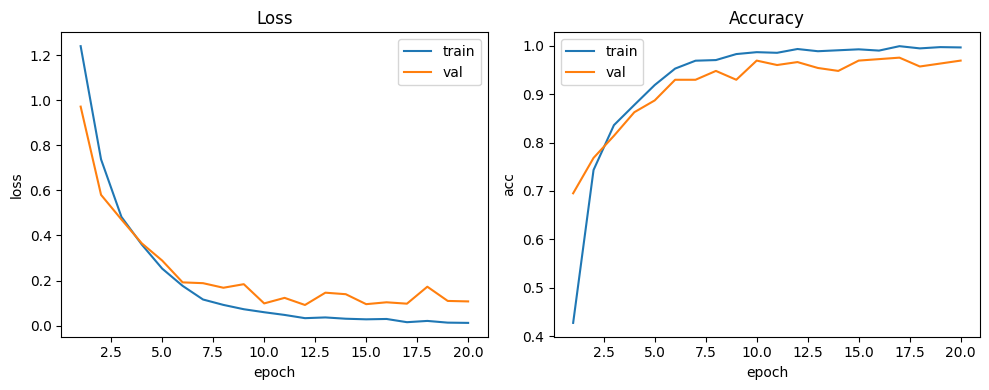

=== Model A — Test Classification Report ===
               precision    recall  f1-score   support

        rock     0.9643    0.9908    0.9774       109
       paper     0.9615    0.9346    0.9479       107
    scissors     0.9558    0.9558    0.9558       113

    accuracy                         0.9605       329
   macro avg     0.9605    0.9604    0.9603       329
weighted avg     0.9605    0.9605    0.9604       329



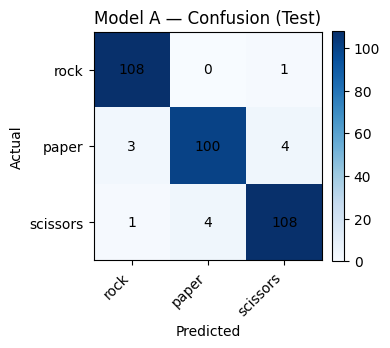

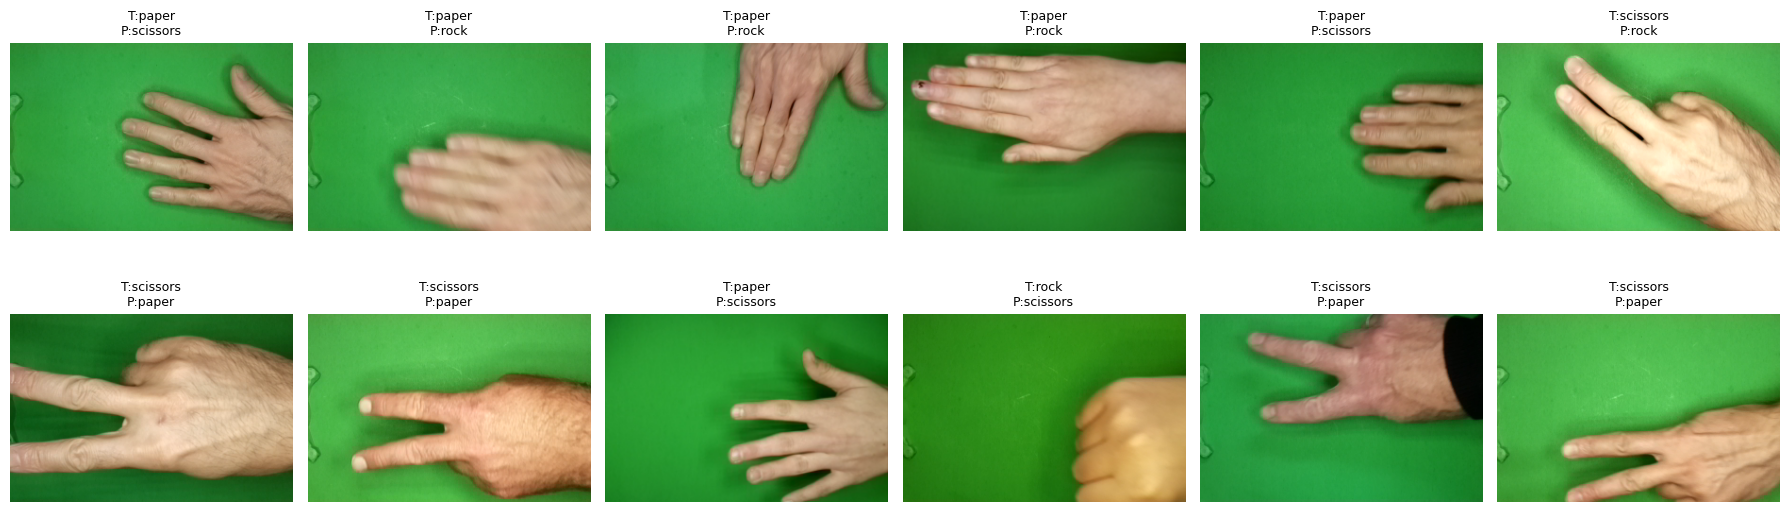

In [14]:
model_a = ModelA(num_classes=len(CLASSES))
params_a = count_params(model_a)
print(f"Model A trainable params: {params_a:,}")

hist_a, ckpt_a, secs_a = timed_train(
    model_a, train_ld, val_ld,
    epochs=EPOCHS_A, lr=LR_DEFAULT, weight_decay=WEIGHT_DECAY,
    ckpt_name="best_A.pt"
)
print(f"Model A training time: {secs_a/60:.2f} min")

plot_curves(hist_a, OUT_PLOTS / "curves_A.png")

state = torch.load(ckpt_a, map_location=DEVICE)
model_a.load_state_dict(state["model_state"])

ys_a, ps_a, paths_a, report_a, cm_a = final_test_report(model_a, test_ld, CLASSES)
print("=== Model A — Test Classification Report ===\n", report_a)

plot_confusion(cm_a, CLASSES, OUT_PLOTS / "confusion_A_test.png", title="Model A — Confusion (Test)")
misclass_gallery(paths_a, ys_a, ps_a, CLASSES, n=12, save_path=OUT_PLOTS / "misclass_A.png")

# Train & evaluate Model B with a tiny LR×Epochs grid

I ran a tiny grid on **Model B** (LR ∈ {1e-3, 3e-4}; epochs ∈ {20, 25}) and kept the best by validation accuracy.

*Model B completed multiple short runs, allowing a quick hyperparameter comparison and yielding a stronger result than Model A.*

Model B trainable params: 8,449,635

--- Training Model B (lr=0.001, epochs=20) ---


[01] train_loss=0.9081 acc=0.580 | val_loss=0.7160 acc=0.713


[02] train_loss=0.4480 acc=0.830 | val_loss=0.3046 acc=0.881


[03] train_loss=0.2692 acc=0.906 | val_loss=0.3103 acc=0.896


[04] train_loss=0.1729 acc=0.936 | val_loss=0.1301 acc=0.957


[05] train_loss=0.0834 acc=0.973 | val_loss=0.1017 acc=0.970


[06] train_loss=0.0488 acc=0.985 | val_loss=0.0646 acc=0.982


[07] train_loss=0.0942 acc=0.969 | val_loss=0.1815 acc=0.927


[08] train_loss=0.0719 acc=0.980 | val_loss=0.0620 acc=0.985


[09] train_loss=0.0289 acc=0.991 | val_loss=0.0453 acc=0.985


[10] train_loss=0.0248 acc=0.992 | val_loss=0.0392 acc=0.988


[11] train_loss=0.0205 acc=0.994 | val_loss=0.0381 acc=0.991


[12] train_loss=0.0160 acc=0.995 | val_loss=0.0443 acc=0.991


[13] train_loss=0.0159 acc=0.995 | val_loss=0.0311 acc=0.988


[14] train_loss=0.0101 acc=0.997 | val_loss=0.0463 acc=0.988


[15] train_loss=0.0120 acc=0.996 | val_loss=0.0392 acc=0.988


[16] train_loss=0.0223 acc=0.993 | val_loss=0.0813 acc=0.979


[17] train_loss=0.0277 acc=0.992 | val_loss=0.0795 acc=0.979


[18] train_loss=0.0124 acc=0.997 | val_loss=0.0374 acc=0.988


[19] train_loss=0.0118 acc=0.997 | val_loss=0.0821 acc=0.966


[20] train_loss=0.0052 acc=0.999 | val_loss=0.0576 acc=0.988
Val best acc: 0.9909 | train time: 8.71 min

--- Training Model B (lr=0.001, epochs=25) ---


[01] train_loss=1.0345 acc=0.516 | val_loss=0.6987 acc=0.723


[02] train_loss=0.5190 acc=0.799 | val_loss=0.3732 acc=0.863


[03] train_loss=0.2179 acc=0.926 | val_loss=0.1738 acc=0.948


[04] train_loss=0.0986 acc=0.967 | val_loss=0.1190 acc=0.954


[05] train_loss=0.0754 acc=0.977 | val_loss=0.0684 acc=0.979


[06] train_loss=0.0397 acc=0.986 | val_loss=0.0553 acc=0.982


[07] train_loss=0.0408 acc=0.987 | val_loss=0.0380 acc=0.991


[08] train_loss=0.0330 acc=0.991 | val_loss=0.0454 acc=0.985


[09] train_loss=0.0421 acc=0.984 | val_loss=0.0249 acc=0.988


[10] train_loss=0.0196 acc=0.995 | val_loss=0.0382 acc=0.982


[11] train_loss=0.0259 acc=0.991 | val_loss=0.0403 acc=0.988


[12] train_loss=0.0212 acc=0.995 | val_loss=0.0445 acc=0.988


[13] train_loss=0.0216 acc=0.992 | val_loss=0.0255 acc=0.985


[14] train_loss=0.0139 acc=0.996 | val_loss=0.0284 acc=0.988


[15] train_loss=0.0333 acc=0.986 | val_loss=0.0859 acc=0.963


[16] train_loss=0.0236 acc=0.992 | val_loss=0.0423 acc=0.982


[17] train_loss=0.0079 acc=0.999 | val_loss=0.0188 acc=0.988


[18] train_loss=0.0185 acc=0.995 | val_loss=0.0272 acc=0.991


[19] train_loss=0.0159 acc=0.995 | val_loss=0.0929 acc=0.985


[20] train_loss=0.0098 acc=0.997 | val_loss=0.0326 acc=0.988


[21] train_loss=0.0796 acc=0.973 | val_loss=0.0391 acc=0.988


[22] train_loss=0.0272 acc=0.989 | val_loss=0.0282 acc=0.991


[23] train_loss=0.0134 acc=0.997 | val_loss=0.0480 acc=0.985


[24] train_loss=0.0075 acc=0.999 | val_loss=0.0251 acc=0.994


[25] train_loss=0.0096 acc=0.997 | val_loss=0.0344 acc=0.988
Val best acc: 0.9939 | train time: 9.86 min

--- Training Model B (lr=0.0003, epochs=20) ---


[01] train_loss=0.9259 acc=0.549 | val_loss=0.7751 acc=0.671


[02] train_loss=0.6268 acc=0.758 | val_loss=0.6237 acc=0.735


[03] train_loss=0.4440 acc=0.833 | val_loss=0.3801 acc=0.854


[04] train_loss=0.3079 acc=0.895 | val_loss=0.2626 acc=0.912


[05] train_loss=0.2006 acc=0.933 | val_loss=0.1720 acc=0.945


[06] train_loss=0.1228 acc=0.962 | val_loss=0.1324 acc=0.954


[07] train_loss=0.1039 acc=0.966 | val_loss=0.1007 acc=0.960


[08] train_loss=0.0761 acc=0.979 | val_loss=0.1028 acc=0.970


[09] train_loss=0.0531 acc=0.981 | val_loss=0.0829 acc=0.973


[10] train_loss=0.0397 acc=0.988 | val_loss=0.0854 acc=0.973


[11] train_loss=0.0419 acc=0.989 | val_loss=0.0681 acc=0.982


[12] train_loss=0.0279 acc=0.993 | val_loss=0.1004 acc=0.976


[13] train_loss=0.0252 acc=0.994 | val_loss=0.1088 acc=0.973


[14] train_loss=0.0296 acc=0.993 | val_loss=0.0692 acc=0.979


[15] train_loss=0.0261 acc=0.992 | val_loss=0.0548 acc=0.988


[16] train_loss=0.0292 acc=0.990 | val_loss=0.0967 acc=0.976


[17] train_loss=0.0380 acc=0.985 | val_loss=0.1257 acc=0.960


[18] train_loss=0.0382 acc=0.986 | val_loss=0.0539 acc=0.985


[19] train_loss=0.0226 acc=0.993 | val_loss=0.0782 acc=0.985


[20] train_loss=0.0244 acc=0.991 | val_loss=0.0789 acc=0.976
Val best acc: 0.9878 | train time: 7.84 min

--- Training Model B (lr=0.0003, epochs=25) ---


[01] train_loss=0.9298 acc=0.555 | val_loss=0.7025 acc=0.716


[02] train_loss=0.5574 acc=0.775 | val_loss=0.5943 acc=0.759


[03] train_loss=0.4221 acc=0.837 | val_loss=0.3447 acc=0.878


[04] train_loss=0.2663 acc=0.908 | val_loss=0.2168 acc=0.933


[05] train_loss=0.1741 acc=0.946 | val_loss=0.3103 acc=0.905


[06] train_loss=0.1635 acc=0.947 | val_loss=0.1504 acc=0.939


[07] train_loss=0.1215 acc=0.955 | val_loss=0.1163 acc=0.963


[08] train_loss=0.0764 acc=0.974 | val_loss=0.1383 acc=0.945


[09] train_loss=0.0840 acc=0.977 | val_loss=0.1637 acc=0.936


[10] train_loss=0.0677 acc=0.972 | val_loss=0.1265 acc=0.951


[11] train_loss=0.0787 acc=0.968 | val_loss=0.0959 acc=0.951


[12] train_loss=0.0549 acc=0.982 | val_loss=0.0662 acc=0.985


[13] train_loss=0.0271 acc=0.991 | val_loss=0.0508 acc=0.982


[14] train_loss=0.0244 acc=0.993 | val_loss=0.0437 acc=0.982


[15] train_loss=0.0235 acc=0.995 | val_loss=0.0502 acc=0.985


[16] train_loss=0.0242 acc=0.994 | val_loss=0.0885 acc=0.976


[17] train_loss=0.0182 acc=0.995 | val_loss=0.0451 acc=0.979


[18] train_loss=0.0126 acc=0.997 | val_loss=0.0470 acc=0.985


[19] train_loss=0.0155 acc=0.995 | val_loss=0.0421 acc=0.985


[20] train_loss=0.0106 acc=0.999 | val_loss=0.0423 acc=0.985


[21] train_loss=0.0397 acc=0.987 | val_loss=0.0495 acc=0.976


[22] train_loss=0.0218 acc=0.994 | val_loss=0.0533 acc=0.973


[23] train_loss=0.0133 acc=0.997 | val_loss=0.1289 acc=0.973


[24] train_loss=0.0146 acc=0.997 | val_loss=0.0496 acc=0.979


[25] train_loss=0.0136 acc=0.997 | val_loss=0.0849 acc=0.985
Val best acc: 0.9848 | train time: 9.80 min

Best Model B config: lr=0.001, epochs=25 | val_acc=0.9939 | train time=9.86 min


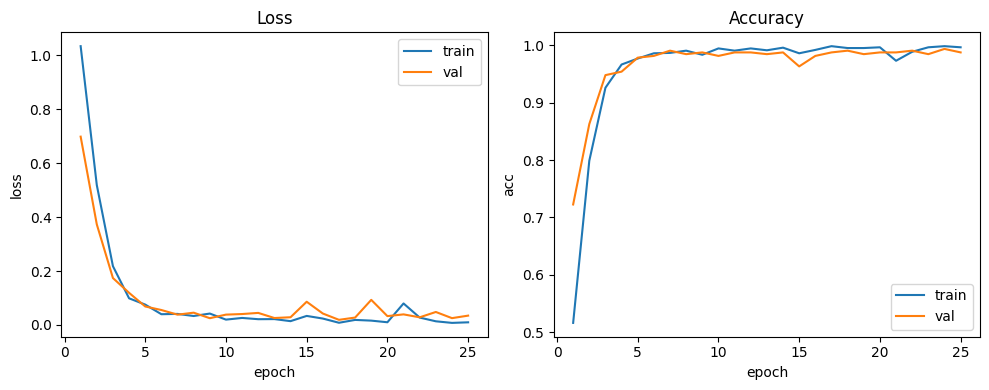

=== Model B — Test Classification Report ===
               precision    recall  f1-score   support

        rock     0.9474    0.9908    0.9686       109
       paper     0.9804    0.9346    0.9569       107
    scissors     0.9646    0.9646    0.9646       113

    accuracy                         0.9635       329
   macro avg     0.9641    0.9633    0.9634       329
weighted avg     0.9640    0.9635    0.9634       329



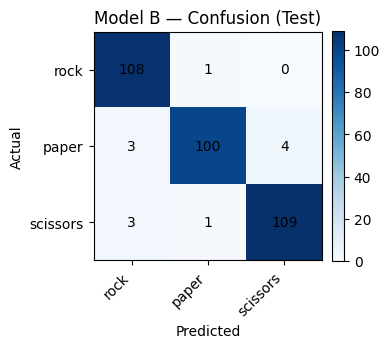

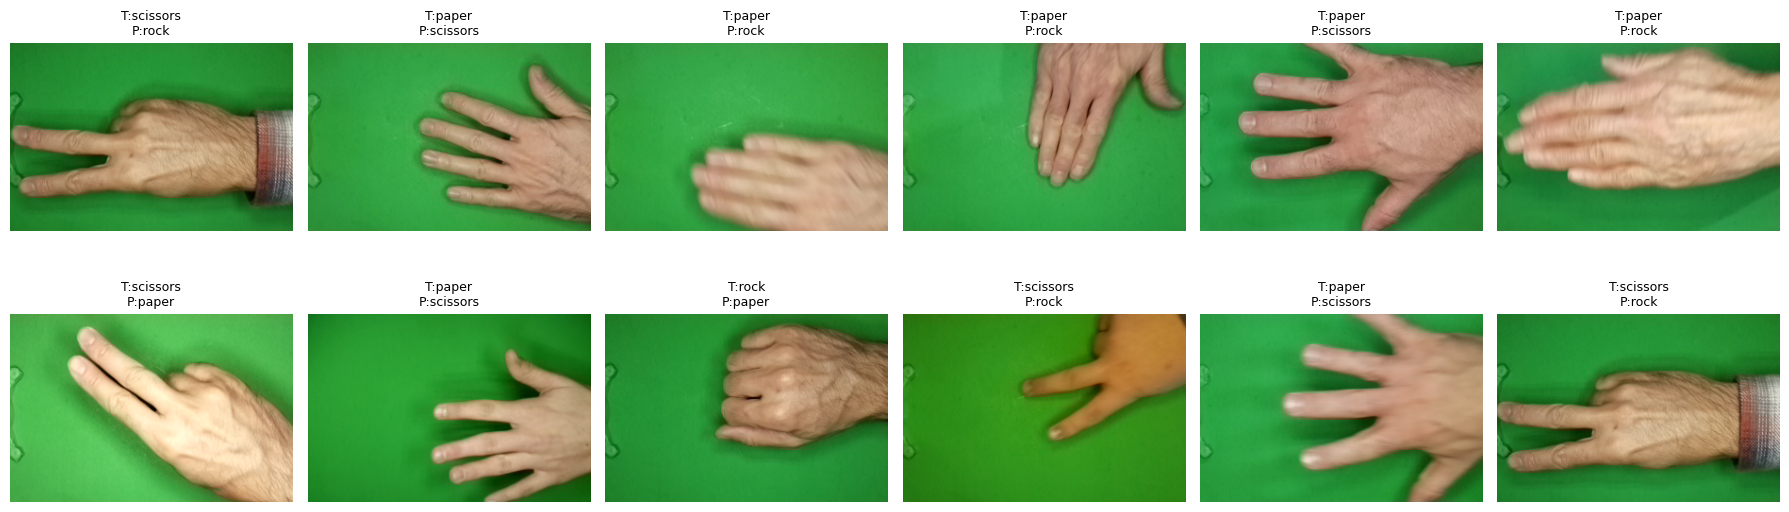

In [15]:
grid_lrs    = [1e-3, 3e-4]
grid_epochs = [20, 25]

params_b_ref = count_params(ModelB(num_classes=len(CLASSES)))
print(f"Model B trainable params: {params_b_ref:,}")

best_val_acc, best_cfg, best_hist, best_ckpt, best_secs = -1.0, None, None, None, None

for lr in grid_lrs:
    for ep in grid_epochs:
        print(f"\n--- Training Model B (lr={lr}, epochs={ep}) ---")
        model_b = ModelB(num_classes=len(CLASSES))
        hist_b, ckpt_b, secs_b = timed_train(
            model_b, train_ld, val_ld,
            epochs=ep, lr=lr, weight_decay=WEIGHT_DECAY,
            ckpt_name=f"best_B_lr{lr}_ep{ep}.pt"
        )
        val_acc = max(hist_b["val_acc"])
        print(f"Val best acc: {val_acc:.4f} | train time: {secs_b/60:.2f} min")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_cfg, best_hist, best_ckpt, best_secs = (lr, ep), hist_b, ckpt_b, secs_b

print(f"\nBest Model B config: lr={best_cfg[0]}, epochs={best_cfg[1]} | val_acc={best_val_acc:.4f} | train time={best_secs/60:.2f} min")
plot_curves(best_hist, OUT_PLOTS / "curves_B.png")

best_b = ModelB(num_classes=len(CLASSES)).to(DEVICE)
state_b = torch.load(best_ckpt, map_location=DEVICE)
best_b.load_state_dict(state_b["model_state"])

ys_b, ps_b, paths_b, report_b, cm_b = final_test_report(best_b, test_ld, CLASSES)
print("=== Model B — Test Classification Report ===\n", report_b)
plot_confusion(cm_b, CLASSES, OUT_PLOTS / "confusion_B_test.png", title="Model B — Confusion (Test)")
misclass_gallery(paths_b, ys_b, ps_b, CLASSES, n=12, save_path=OUT_PLOTS / "misclass_B.png")

# Train & evaluate Model C

I trained **Model C** using **[best LR from B or 1e-3]** for **20 epochs** and evaluated on the test set.

Model C trainable params: 33,694,883


[01] train_loss=1.1088 acc=0.419 | val_loss=0.9833 acc=0.537


[02] train_loss=0.7977 acc=0.648 | val_loss=0.6935 acc=0.710


[03] train_loss=0.5668 acc=0.782 | val_loss=0.4947 acc=0.805


[04] train_loss=0.4189 acc=0.835 | val_loss=0.2815 acc=0.878


[05] train_loss=0.2689 acc=0.909 | val_loss=0.1913 acc=0.930


[06] train_loss=0.1564 acc=0.944 | val_loss=0.1458 acc=0.936


[07] train_loss=0.1173 acc=0.963 | val_loss=0.0913 acc=0.979


[08] train_loss=0.0713 acc=0.972 | val_loss=0.0600 acc=0.976


[09] train_loss=0.0572 acc=0.985 | val_loss=0.0597 acc=0.979


[10] train_loss=0.0447 acc=0.986 | val_loss=0.0353 acc=0.988


[11] train_loss=0.0813 acc=0.973 | val_loss=0.0840 acc=0.979


[12] train_loss=0.0528 acc=0.982 | val_loss=0.0365 acc=0.988


[13] train_loss=0.0375 acc=0.992 | val_loss=0.0316 acc=0.988


[14] train_loss=0.0274 acc=0.992 | val_loss=0.0630 acc=0.976


[15] train_loss=0.0416 acc=0.987 | val_loss=0.0456 acc=0.985


[16] train_loss=0.0511 acc=0.985 | val_loss=0.1858 acc=0.954


[17] train_loss=0.0363 acc=0.990 | val_loss=0.0448 acc=0.982


[18] train_loss=0.0221 acc=0.993 | val_loss=0.0487 acc=0.982


[19] train_loss=0.0139 acc=0.997 | val_loss=0.0472 acc=0.985


[20] train_loss=0.0238 acc=0.994 | val_loss=0.0274 acc=0.991
Model C training time: 9.96 min


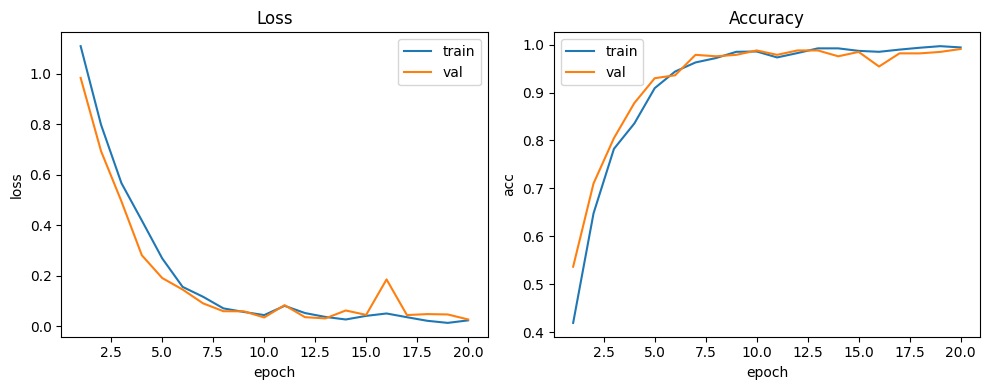

=== Model C — Test Classification Report ===
               precision    recall  f1-score   support

        rock     0.9730    0.9908    0.9818       109
       paper     0.9717    0.9626    0.9671       107
    scissors     0.9911    0.9823    0.9867       113

    accuracy                         0.9787       329
   macro avg     0.9786    0.9786    0.9785       329
weighted avg     0.9788    0.9787    0.9787       329



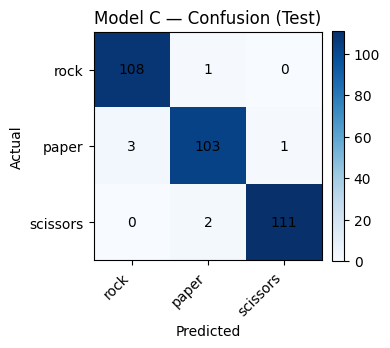

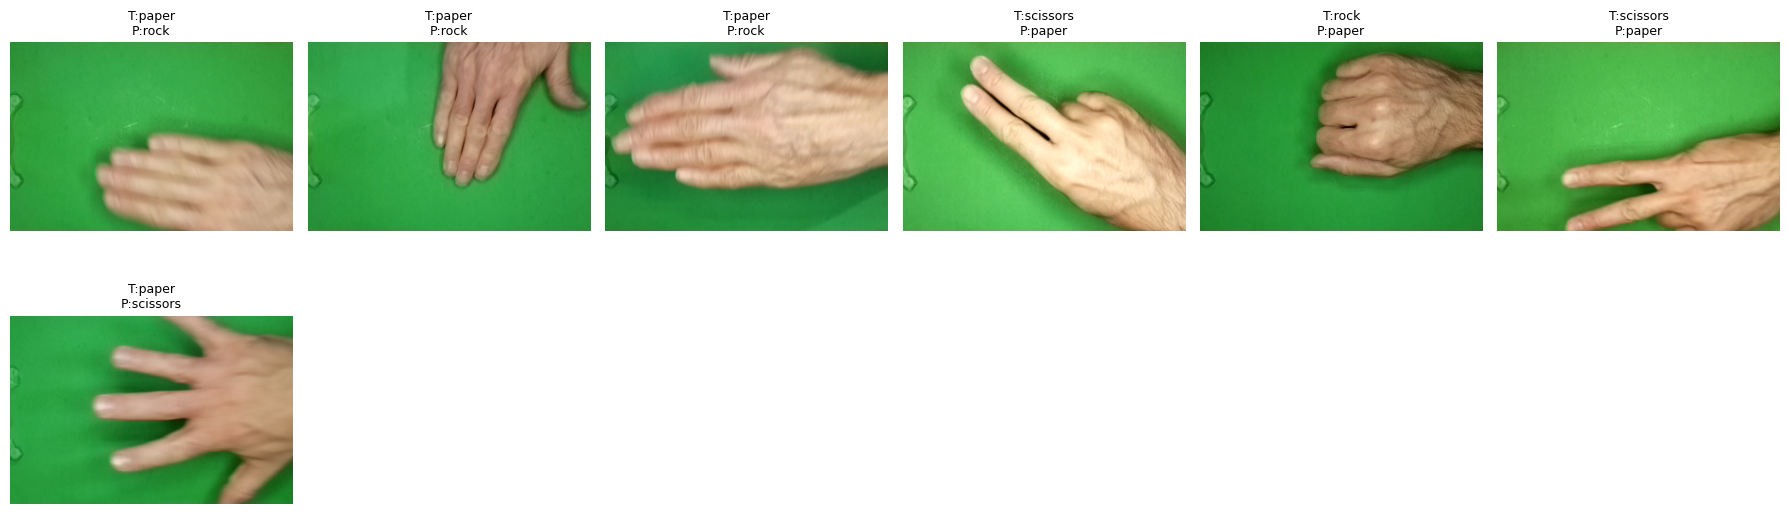

In [16]:
lr_c = best_cfg[0] if best_cfg is not None else LR_DEFAULT

model_c = ModelC(num_classes=len(CLASSES))
params_c = count_params(model_c)
print(f"Model C trainable params: {params_c:,}")

hist_c, ckpt_c, secs_c = timed_train(
    model_c, train_ld, val_ld,
    epochs=EPOCHS_C, lr=lr_c, weight_decay=WEIGHT_DECAY,
    ckpt_name="best_C.pt"
)
print(f"Model C training time: {secs_c/60:.2f} min")

plot_curves(hist_c, OUT_PLOTS / "curves_C.png")

# Evaluate on test
state_c = torch.load(ckpt_c, map_location=DEVICE)
model_c.load_state_dict(state_c["model_state"])

ys_c, ps_c, paths_c, report_c, cm_c = final_test_report(model_c, test_ld, CLASSES)
print("=== Model C — Test Classification Report ===\n", report_c)
plot_confusion(cm_c, CLASSES, OUT_PLOTS / "confusion_C_test.png", title="Model C — Confusion (Test)")
misclass_gallery(paths_c, ys_c, ps_c, CLASSES, n=12, save_path=OUT_PLOTS / "misclass_C.png")

# Short Comparison Summary

I compared A/B/C on params, training time, and validation/test performance.

*This section consolidates results and observations from all models, showing how accuracy and complexity relate.*

In [17]:
summary_rows = [
    {
        "Model": "A",
        "Params": params_a if "params_a" in locals() else None,
        "Best_Val_Acc": round(max(hist_a["val_acc"]), 4) if "hist_a" in locals() else None,
        "Test_Acc": round(float(classification_report(ys_a, ps_a, output_dict=True)["accuracy"]), 4) if "ys_a" in locals() else None,
        "Train_Time_min": round(secs_a / 60, 2) if "secs_a" in locals() else None,
    },
    {
        "Model": "B",
        "Params": params_b_ref if "params_b_ref" in locals() else None,
        "Best_Val_Acc": round(best_val_acc, 4) if "best_val_acc" in locals() else None,
        "Test_Acc": round(float(classification_report(ys_b, ps_b, output_dict=True)["accuracy"]), 4) if "ys_b" in locals() else None,
        "Train_Time_min": round(best_secs / 60, 2) if "best_secs" in locals() else None,
    },
    {
        "Model": "C",
        "Params": params_c if "params_c" in locals() else None,
        "Best_Val_Acc": round(max(hist_c["val_acc"]), 4) if "hist_c" in locals() else None,
        "Test_Acc": round(float(classification_report(ys_c, ps_c, output_dict=True)["accuracy"]), 4) if "ys_c" in locals() else None,
        "Train_Time_min": round(secs_c / 60, 2) if "secs_c" in locals() else None,
    },
]

metrics_df = pd.DataFrame(summary_rows)
display(metrics_df)

,Model,Params,Best_Val_Acc,Test_Acc,Train_Time_min
0,A,2102499,0.9756,0.9605,3.10
1,B,8449635,0.9939,0.9635,9.86
2,C,33694883,0.9909,0.9787,9.96
